In [29]:
import numpy as np
inf=float("inf")

import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import scipy.stats as st

from scipy.cluster import hierarchy

import stablerank.srank as sr
import stablerank.geometry_objects_2020 as ge

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import _pickle as pickle

from ripser import ripser
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from PIL import Image

import os

#from keras.datasets import mnist
#from matplotlib import pyplot

In [2]:
# loading the data

df=pd.read_csv('challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv', sep=',')
#df=pd.read_csv('challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv', sep=',',header=None)

In [3]:
# Removing duplicate values and reindexing

df.drop_duplicates(subset =[" pixels"], inplace = True)
df=df.reindex(range(0,len(df)-1))

In [4]:
df

,emotion,Usage,pixels
0,0.0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0.0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2.0,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4.0,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6.0,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
34028,0.0,PrivateTest,157 157 157 157 156 156 155 155 157 155 155 14...
34029,3.0,PrivateTest,24 33 41 48 48 58 75 95 110 139 158 172 178 18...
34030,5.0,PrivateTest,42 70 65 49 34 33 34 39 58 61 86 86 68 93 76 5...
34031,0.0,PrivateTest,49 47 51 60 60 61 66 70 74 74 70 63 65 75 69 6...


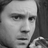

In [5]:
# Printing the first picture
first_picture = [int(numeric_string) for numeric_string in df[" pixels"][0].split(' ')]
first_picture_arr = np.array(first_picture)
first_picture_arr.resize((48,48))
im = Image.fromarray((255-first_picture_arr* 255).astype(np.uint8))
im

In [6]:
#Schmierblatt

pos = np.array(np.where(df["emotion"]==3))[0]
rand_pos = pos[list(np.random.permutation(np.arange(0,len(pos)-1))[:20])]
points_dummy = np.empty((len(rand_pos),48*48), int)

for i in range(0,len(rand_pos)):
    points_dummy[i] = [int(numeric_string) for numeric_string in df[" pixels"][rand_pos[i]].split(' ')]

points = np.vstack(points_dummy)
#df[" pixels"].loc[pos]

In [7]:
angry = sr.EucObject(points)
print("size: ", angry.size)
print("dimension: ", angry.dim)
print("points: ", angry.points)

size:  20
dimension:  2304
points:  [[241. 244. 246. ... 166. 157. 135.]
 [ 17.  22.  16. ...  40.  40.  35.]
 [ 82.  90.  81. ...  76.  79.  83.]
 ...
 [224. 170. 109. ... 222. 224. 235.]
 [150. 141. 130. ...  13.  14.  15.]
 [255. 255. 255. ... 167. 245. 255.]]


In [8]:
# specifying metric
metric = "minkowski"
metric_parameter = 3

# specifying clustering method
clustering_method = "complete"


f1 = angry.get_h0sr(metric = metric, metric_parameter = metric_parameter)


#plt.figure(figsize=(20,20))

#f1.plot(color ="blue")

# $H_0$ stable rank for embedding 1

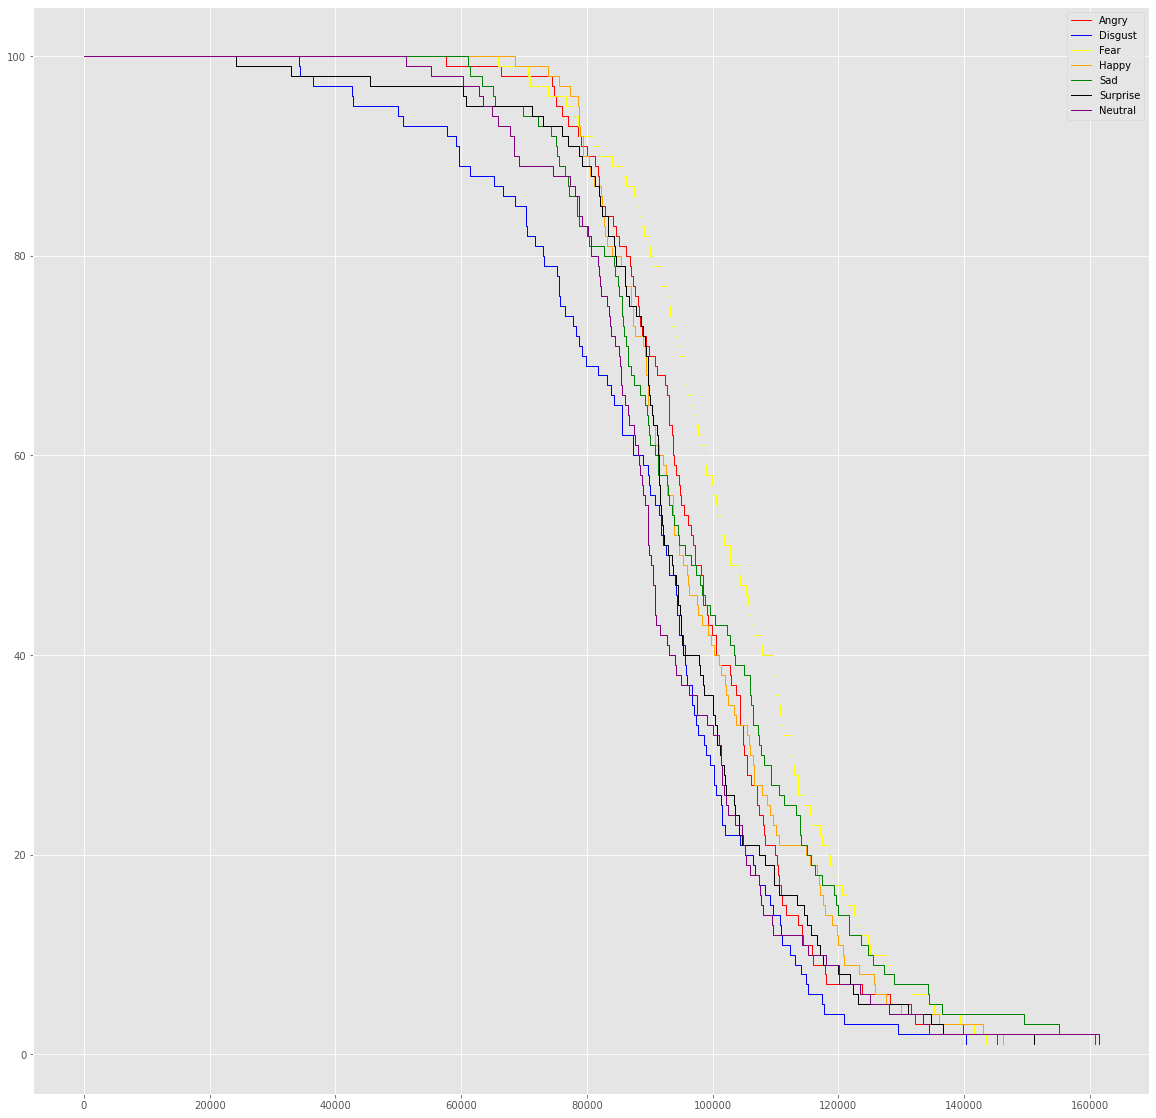

In [9]:
#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
emotion_categories = [0,1,2,3,4,5,6]
colours=["red","blue","yellow","orange","green","black","purple"]
legends = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# specifying the number of pictures for subsampling
number_of_pictures = 100

# specifying metric
metric = "cityblock"
#metric_parameter = 3

# specifying clustering method
clustering_method = "single"

plt.figure(figsize=(20,20))

for e in emotion_categories:
    pos = np.array(np.where(df["emotion"]==e))[0]
    #rand_pos = pos[np.random.randint(0,len(pos)-1,number_of_pictures)]
    rand_pos = pos[list(np.random.permutation(np.arange(0,len(pos)-1))[:number_of_pictures])]
    points_dummy = np.empty((len(rand_pos),48*48), int)

    for i in range(0,len(rand_pos)):
        points_dummy[i] = [int(numeric_string) for numeric_string in df[" pixels"][rand_pos[i]].split(' ')]

    points = np.vstack(points_dummy)
    
    point_cloud = sr.EucObject(points)
    
    f_pcf = point_cloud.get_h0sr(metric = metric, metric_parameter = metric_parameter)
    
    f_pcf.plot(color=colours[emotion_categories.index(e)])

    #print("size: ", point_cloud.size)
    #print("dimension: ", point_cloud.dim)
    #print("points: ", point_cloud.points)
plt.legend(legends)

# Dendrogram from embedding 1

In [11]:
def big_list(T):
    L=[]
    for i in range(len(T)):
        L=L+list(T[i])
    return L

array([ 57,  58,  62, ..., 147,  46, 104])

array([197, 180, 147, ..., 220,  41,  55])

array([ 22,  20,  20, ..., 140, 135, 130])

array([47, 48, 49, ..., 56, 57, 54])

array([255, 255, 255, ..., 174, 199, 208])

array([245, 250, 124, ..., 229, 217, 230])

array([33, 47, 41, ..., 39, 30, 21])

[[ 57  58  62 ... 147  46 104]
 [197 180 147 ... 220  41  55]
 [ 22  20  20 ... 140 135 130]
 ...
 [255 255 255 ... 174 199 208]
 [245 250 124 ... 229 217 230]
 [ 33  47  41 ...  39  30  21]]


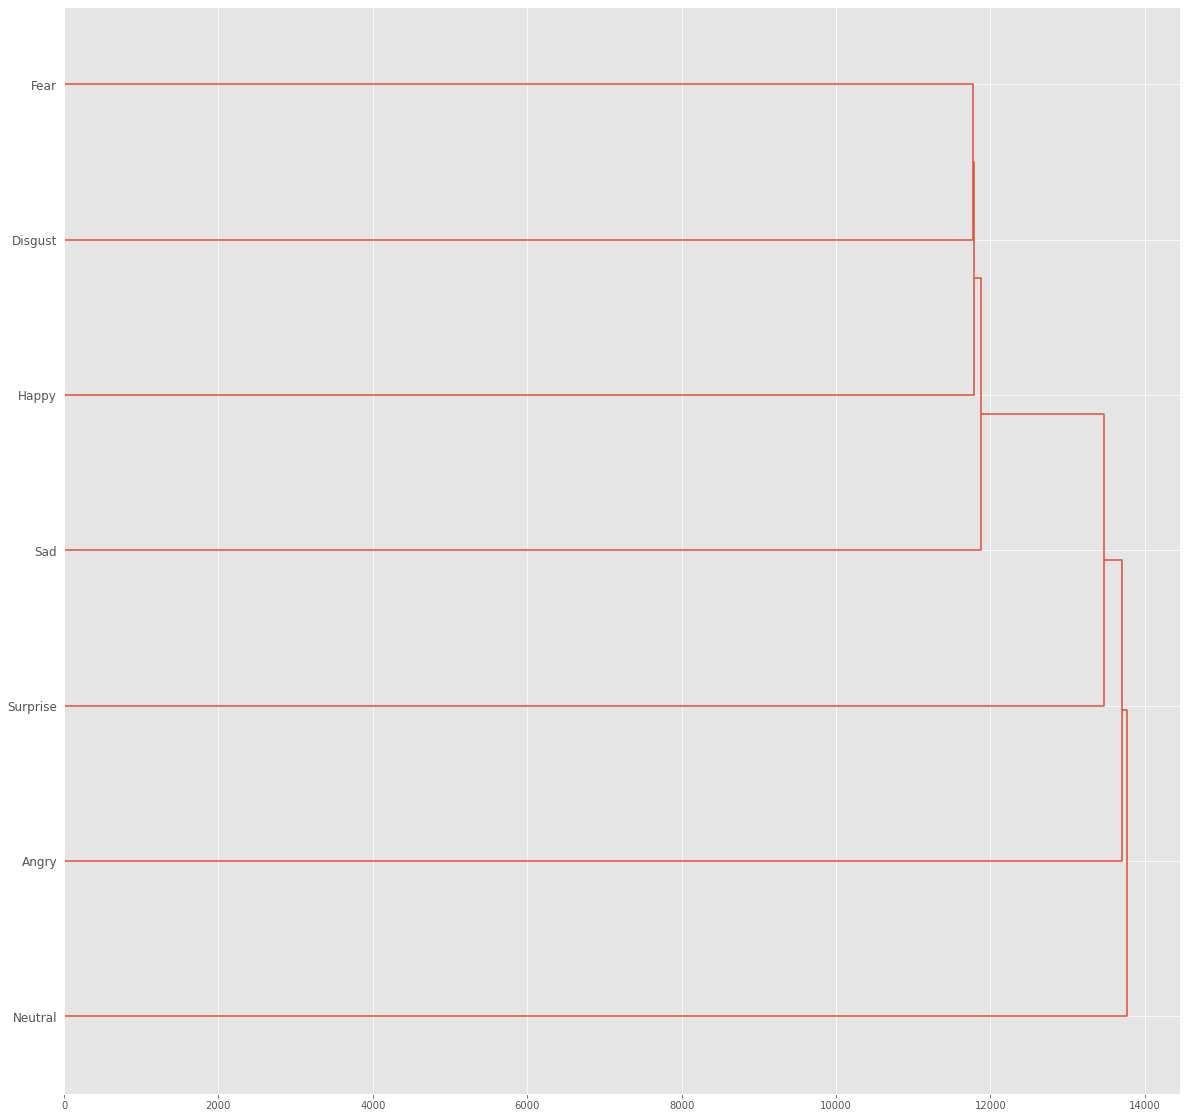

In [37]:
#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
emotion_categories = [0,1,2,3,4,5,6]
#colours=["red","blue","yellow","orange","green","black","purple"]
legends = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# specifying the number of pictures for subsampling
number_of_pictures = 10

plt.figure(figsize=(20,20))

#points = np.array([])
points=[]
for e in emotion_categories:
    pos = np.array(np.where(df["emotion"]==e))[0]
    #rand_pos = pos[np.random.randint(0,len(pos)-1,number_of_pictures)]
    rand_pos = pos[list(np.random.permutation(np.arange(0,len(pos)-1))[:number_of_pictures])]
    points_dummy = np.empty((len(rand_pos),48*48), int)

    for i in range(0,len(rand_pos)):
        points_dummy[i] = [int(numeric_string) for numeric_string in df[" pixels"][rand_pos[i]].split(' ')]
    
    points_stack = big_list(points_dummy)
    points.append(points_stack)
    display(np.hstack(points_stack))
    
print(np.array(points))
Z = hierarchy.linkage(points, 'single')
hierarchy.dendrogram(Z, orientation = 'right', labels = legends)
hierarchy.set_link_color_palette(["red","blue","yellow","orange","green","black","purple"])
plt.savefig("dendrogram.pdf")
os.system('pdfcrop %s %s' % ("dendrogram.pdf", "dendrogram.pdf"))
plt.show()